In [1]:
import pandas as pd
from ipynb.fs.full.extract_raw_data import extra_raw_data
from ipynb.fs.full.extract_raw_data import generate_balanced_aa_antigen_table

ipynb.fs.full.extract_raw_data:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.extract_raw_data:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.extract_raw_data:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipynb.fs.full.extract_raw_data:

In [2]:
# load data
dt = extra_raw_data()
balanced_aa_antigen_table = generate_balanced_aa_antigen_table(dt)

In [3]:
# function to convert sequence strings into k-mer words, default size = 6 (hexamer words)
def getKmers(sequence, size=6):
    return [sequence[x:x+size].upper() for x in range(len(sequence) - size + 1)]

In [4]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import MultinomialNB
# plot ROC curve
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [5]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
def get_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    return accuracy, precision, recall, f1

In [6]:
 # Convert our data sequences into short overlapping k-mers of legth 6 using our getKmers function.
balanced_aa_antigen_table['aa_words'] =  balanced_aa_antigen_table.apply(lambda x: getKmers(x['aa_1TRB_only'], size = 6), axis=1)


aa_texts = list(balanced_aa_antigen_table['aa_words'])
for item in range(len(balanced_aa_antigen_table)):
    aa_texts[item] = ' '.join(aa_texts[item])
    


In [7]:
# Creating the Bag of Words model using CountVectorizer()
# The n-gram size of 5 was previously determined by testing
ngram = 5

from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range=(ngram,ngram))
X = cv.fit_transform(aa_texts)

In [8]:
y = balanced_aa_antigen_table['classes']

In [9]:
from sklearn.model_selection import train_test_split 
    
# Splitting the dataset into the training set and test set

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.20, 
                                                    random_state=42) 

In [10]:
### Multinomial Naive Bayes Classifier ###
# The alpha parameter was determined by grid search previously

classifier = MultinomialNB(alpha=0.01)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

In [11]:
print("Confusion matrix\n")
print(pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name='Predicted')))
get_metrics(y_test, y_pred)


accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))
    

Confusion matrix

Predicted     0    1
Actual              
0          1654  979
accuracy = 0.717 
precision = 0.731 
recall = 0.717 
f1 = 0.712


Normalized confusion matrix
[[0.84193211 0.15806789]
 [0.40811134 0.59188866]]


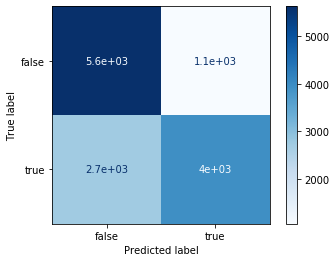

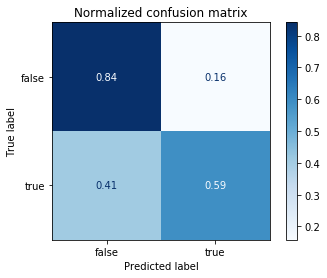

<Figure size 720x720 with 0 Axes>

In [12]:
import matplotlib.pyplot as plt
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, X_test, y_test,
                                 display_labels=['false','true'],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
disp.ax_.set_title(title)
plt.figure(figsize=(10, 10))

print(title)
print(disp.confusion_matrix)

plt.show()

AUC: 0.80


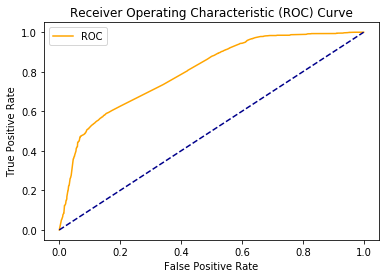

In [13]:
# plot ROC curve 
# Predict probabilities for the test data.
probs = classifier.predict_proba(X_test)
# Keep Probabilities of the positive class only.
probs = probs[:, 1]
# Compute the AUC Score.
auc = roc_auc_score(y_test, probs)
print('AUC: %.2f' % auc)
# Get the ROC Curve.
fpr, tpr, thresholds = roc_curve(y_test, probs)
#  Plot ROC Curve using our defined function
plot_roc_curve(fpr, tpr)